## Classification model과 confusion matrix histogram 간의 관계

In [1]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [3]:
train = pd.read_csv('Data/titanic/train.csv')

In [4]:
train.sample()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
524,525,0,3,"Kassem, Mr. Fared",male,NaN,0,0,2700,7.2292,NaN,C


In [5]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

### Preprocessing

In [6]:
train['Sex'] = train['Sex'].replace('female', 1).replace('male', 0)
train['Family'] = train['SibSp'] + train['Parch'] + 1

In [7]:
train.loc[train['Embarked'].isnull(), 'Embarked'] = 'S'

In [8]:
train = pd.concat([train, pd.get_dummies(train['Embarked'])], axis=1)

In [101]:
train['Married'].value_counts()

1    669
0    222
Name: Married, dtype: int64

In [100]:
train['Married'] = train['Name'].apply(lambda x: x.split('.')[0].split()[-1]).replace('Mr', 1).replace('Mrs', 1).replace('Miss', 0).replace('Master', 0).replace('Dr', 1).replace('Rev', 1).replace('Mlle', 1).replace('Col', 1).replace('Major', 1).replace('Mme', 1).replace('Capt', 1).replace('Countess', 1).replace('Ms', 1).replace('Sir', 1).replace('Don', 1).replace('Jonkheer', 1).replace('Lady', 1)

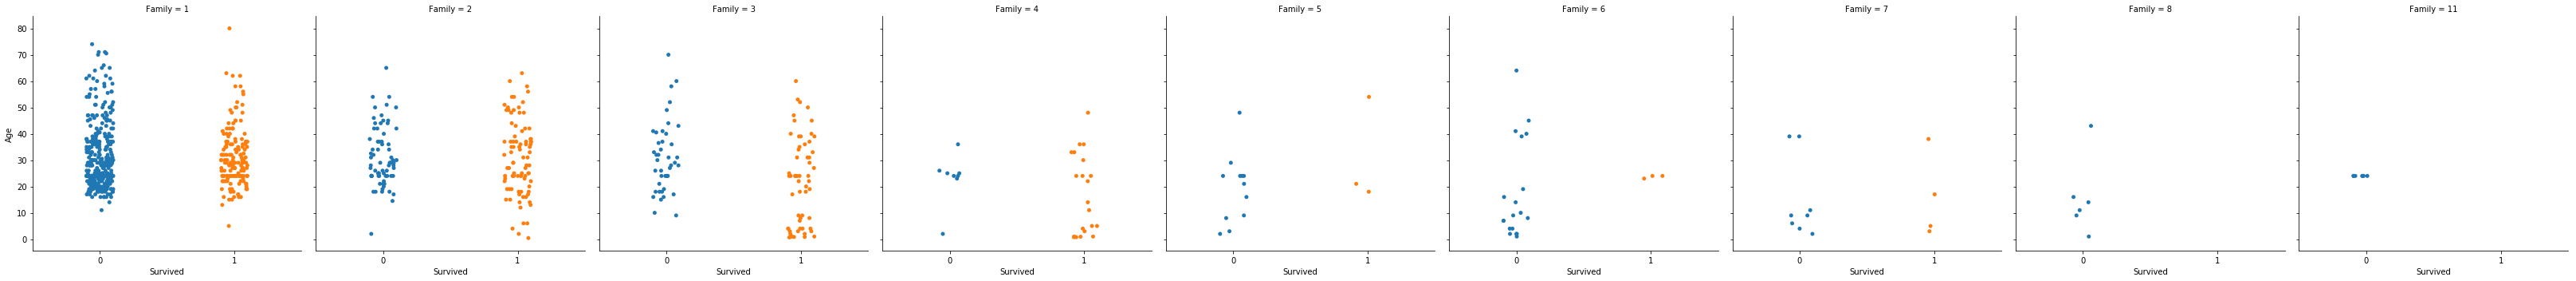

In [92]:
sns.catplot(col='Family', x='Survived', y='Age', data=train)

In [55]:
train['Age'] = train.groupby('Pclass')['Age'].transform(lambda x: x.fillna(x.median()))

In [56]:
train['Age'].isnull().sum()

0

### Split train validation

In [115]:
features = ['Pclass', 'Sex', 'Family', 'C', 'Q', 'S']
# features = ['Pclass', 'Sex', 'Family', 'C', 'Q', 'S', 'Married']

In [116]:
X = train[features]
y = train['Survived']

In [117]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Make classification model

In [118]:
tree = DecisionTreeClassifier(random_state=42)

In [119]:
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

In [120]:
prediction = tree.predict(X_test)

In [121]:
prediction_proba = tree.predict_proba(X_test)[:,1]

In [122]:
y_test = pd.DataFrame(y_test)
y_test.columns = ['Actual']

In [123]:
y_test['Predict'] = prediction
y_test['Predict_proba'] = prediction_proba

### Confusion Matrix

In [124]:
# 기존 Accuracy 0.8044
# Married 추가 0,81

In [125]:
confusion_M = y_test.groupby(['Actual', 'Predict']).size()
confusion_M

Actual  Predict
0       0          97
        1           8
1       0          27
        1          47
dtype: int64

In [113]:
# Accuracy
(confusion_M[0][0] + confusion_M[1][1]) / sum(confusion_M)

0.8100558659217877

### 시각화

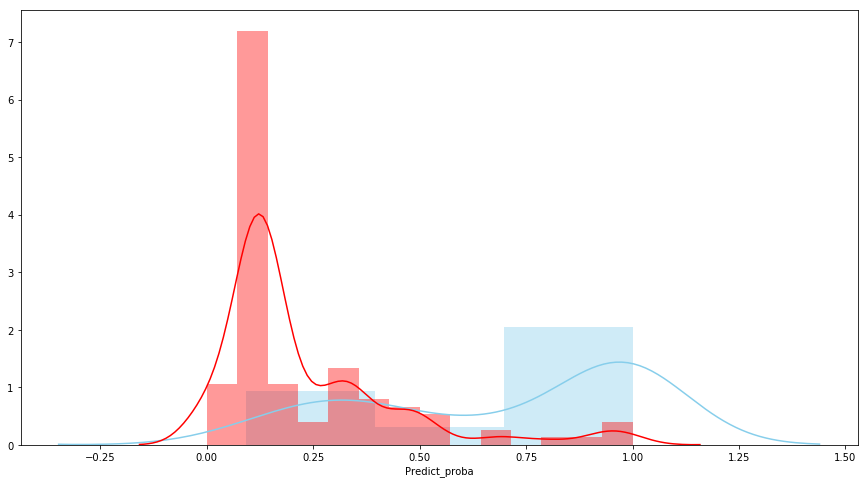

In [126]:
# Pclass, sex, family, S, Q, C
plt.figure(figsize=(15, 8))
sns.distplot(y_test[y_test['Actual']==1]['Predict_proba'], color="skyblue", label="Survived")
sns.distplot(y_test[y_test['Actual']==0]['Predict_proba'], color="Red", label="Dead")

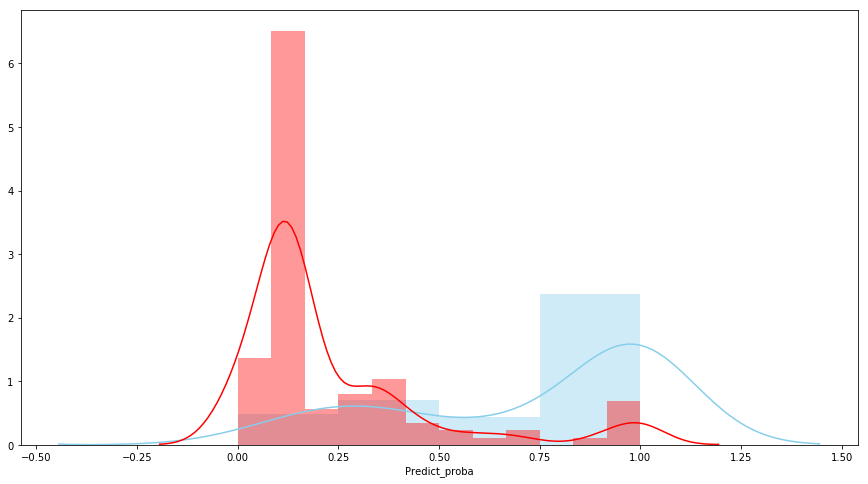

In [114]:
# Pclass, sex, family, S, Q, C, Married
plt.figure(figsize=(15, 8))
sns.distplot(y_test[y_test['Actual']==1]['Predict_proba'], color="skyblue", label="Survived")
sns.distplot(y_test[y_test['Actual']==0]['Predict_proba'], color="Red", label="Dead")

### 미션
* 위의 모델보다 Accuracy가 좋은 모델을 만들고, displot 생김새를 비교해보세요.

In [20]:
# Answer

* Threshold를 움직여가면서 ROC 커브상 좌표를 몇 개만 찾아보세요.

In [139]:
# Threshold 조정 
y_test['Predict_0.21'] = y_test['Predict_proba'] > 0.21
y_test['Predict_0.7'] = y_test['Predict_proba'].apply(lambda x: 1 if x >= 0.7 else 0)
y_test.sample()

,Actual,Predict,Predict_proba,Predict_0.21,Predict_0.7
54,0,0,0.454545,True,0


In [137]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test['Actual'], y_test['Predict'])
tn, fp, fn, tp = confusion.ravel()
print(tn, fp, fn, tp)
confusion

97 8 27 47


array([[97,  8],
       [27, 47]], dtype=int64)

In [138]:
precision = tp / (tp + fp)
recall = tp / (tp + fn)
accuracy = (tp + tn) / (tp + tn + fp + fn)
specificity = tn / (tn + fp)
fell_out = 1-specificity
f1_score = 2 * precision * recall / (precision + recall)

print('precision: ', precision)
print('recall: ', recall)
print('accuracy: ', accuracy)
print('specificity: ', specificity)
print('fell_out: ', fell_out)
print('f1_score: ', f1_score)

precision:  0.8545454545454545
recall:  0.6351351351351351
accuracy:  0.8044692737430168
specificity:  0.9238095238095239
fell_out:  0.07619047619047614
f1_score:  0.7286821705426355


In [136]:
# 0.21
precision = tp / (tp + fp)
recall = tp / (tp + fn)
accuracy = (tp + tn) / (tp + tn + fp + fn)
specificity = tn / (tn + fp)
fell_out = 1-specificity
f1_score = 2 * precision * recall / (precision + recall)

print('precision: ', precision)
print('recall: ', recall)
print('accuracy: ', accuracy)
print('specificity: ', specificity)
print('fell_out: ', fell_out)
print('f1_score: ', f1_score)

precision:  0.6601941747572816
recall:  0.918918918918919
accuracy:  0.770949720670391
specificity:  0.6666666666666666
fell_out:  0.33333333333333337
f1_score:  0.7683615819209041


In [248]:
# Answer
Threshold 움직여가면서
Confusion Matrix 를 그려서
ROC 커브 상 좌표를 몇개 찾아서
ROC 커브를 그려본다
fell-out rate, recall